<a href="https://colab.research.google.com/github/mkjubran/ENEE3309-2-2022/blob/main/FilterAudioSignal_PercentagePowerBandwidth.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!rm -rf ./ENEE3309-2-2022
!git clone https://github.com/mkjubran/ENEE3309-2-2022.git

Cloning into 'ENEE3309-2-2022'...
remote: Enumerating objects: 23, done.
remote: Counting objects: 100% (23/23), done.
remote: Compressing objects: 100% (21/21), done.
remote: Total 23 (delta 7), reused 7 (delta 0), pack-reused 0
Unpacking objects: 100% (23/23), done.


Filter an audio signal based on Percentage Power Bandwidth (PowerBW). The filtered audio signal will contain $PowerBD$ power of the power of the original audio signal.

Duration=20.57496598639456 sec
Energy of wave (time domain)=2809431260.752 KJouls
Power of wave (time domain)=140.42085811888973 Watts
Energy of wave (DS frequency domain)=2809431260.7519784 KJouls
Power of wave (DS frequency domain)=140.42101287717327 Watts

============ BW=11024.951397246505 Hz
Energy of the filtered wave (time domain)=2809431254.899718 KJouls
Power of the filtered wave (time domain)=140.42085782638122 Watts
Energy of the filtered wave (DS frequency domain)=2809431255.065704 KJouls
Power of the filtered wave (DS frequency domain)=140.42101259296186 Watts
Energy Ratio (filtered / original) = 99.99999979169156%

============ BW=5512.475698623252 Hz
Energy of the filtered wave (time domain)=2613584468.4137053 KJouls
Power of the filtered wave (time domain)=130.63205316602742 Watts
Energy of the filtered wave (DS frequency domain)=2613584468.4136744 KJouls
Power of the filtered wave (DS frequency domain)=130.63219713603672 Watts
Energy Ratio (filtered / original) = 93.02

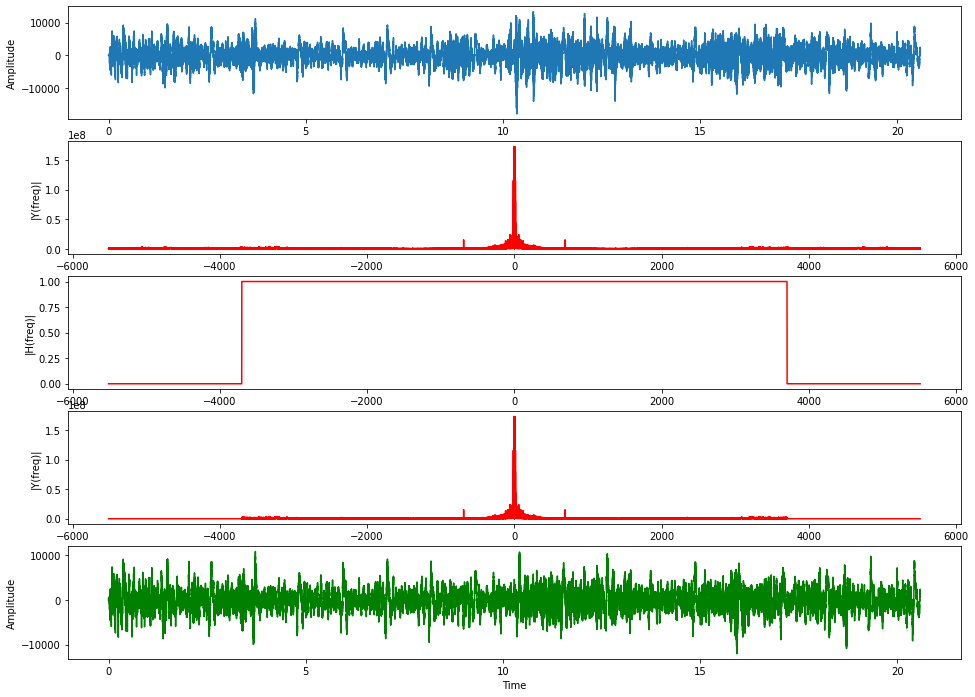

In [6]:
import matplotlib.pyplot as plt 
import numpy as np 
import random 
import scipy 
import wave 
import struct 
import pylab
import pdb
from scipy.io import wavfile

################################################
filenameWave='/content/ENEE3309-2-2022/SunnyDay.wav'
filenameWavefiltered='./Filtered.wav'
filenameWavewithoutfilter='./Withoutfilter.wav'

PowerBW=0.9
write=1
read=1
################################################

rate, data = wavfile.read(filenameWave)
#pdb.set_trace()
if len(data.shape) > 1:
   data=data[:,0]

filtereddata = np.fft.rfft(data, axis=0)

filteredwrite = np.fft.irfft(filtereddata, axis=0)
##############################################
## Generate Signal and add save it to text file
Fs=rate;
Ts = 1.0/Fs; # sampling interval
t = np.arange(0,len(data)*Ts,Ts) # time vector

y=[float(x) for x in data]
## Write values to a file
#Open new data file
if write!=0:
   f = open("Signal_in_text.txt", "w")
   for i in range(len(y)):
       f.write( str(y[i]) + " " + str(float(t[i])) + "\n"  )
   f.close()


## Read values from a file
if read !=0:
   with open('Signal_in_text.txt') as f:
      w=f.read()
   y=[];
   t=[];
   for x in w.split('\n'):
      if x != '':
         y.append(float(x.split()[0]))
         t.append(float(x.split()[1]))


n = len(y) # length of the signal
k = np.arange(n)
T = n/Fs
frq = k/T # two sides frequency range
fcen=frq[int(len(frq)/2)]
frq_DS=frq-fcen
frq_SS = frq[range(int(n/2))] # one side frequency range

Y = np.fft.fft(y) # fft computing and normalization
yinv= np.fft.ifft(Y).real # ifft computing and normalization
Y_DS=np.roll(Y,int(n/2))
Y_SS = Y[range(int(n/2))]

fig, ax = plt.subplots(5, 1,  figsize=(16, 12))
ax[0].plot(t,y)
ax[0].set_xlabel('Time')
ax[0].set_ylabel('Amplitude')
#ax[1].plot(frq_SS,abs(Y_SS),'r') # plotting the spectrum
#ax[1].set_xlabel('Freq (Hz)')
#ax[1].set_ylabel('|Y(freq)|')
ax[1].plot(frq_DS[int(n/4):3*int(n/4)],abs(Y_DS[int(n/4):3*int(n/4)]),'r') # plotting the spectrum
ax[1].set_xlabel('Freq (Hz)')
ax[1].set_ylabel('|Y(freq)|')
#ax[3].plot(t,yinv,'g') # plotting the spectrum
#ax[3].set_xlabel('Time')
#ax[3].set_ylabel('Amplitude')

#plt.show()
y=np.array(y)
y_int=y.astype(np.int16)

yinv=np.array(yinv)
yinv_int=yinv.astype(np.int16)
wavfile.write(filenameWavewithoutfilter, rate, y_int)

Energy_time=np.sum(data.astype(float)**2)
Power_time=1.0/(2*(data.size)+1)*np.sum(data.astype(float)**2)/rate
Energy_freq_DS=np.real(sum(Y_DS*np.conj(Y_DS)))/n
Power_freq_DS=np.real(sum(Y_DS*np.conj(Y_DS)))/(2*(n**2)/(Ts))
print('Duration={} sec'.format(len(y)*Ts))
print('Energy of wave (time domain)={} KJouls'.format(Energy_time/1000))
print('Power of wave (time domain)={} Watts'.format(Power_time))
print('Energy of wave (DS frequency domain)={} KJouls'.format(Energy_freq_DS/1000))
print('Power of wave (DS frequency domain)={} Watts'.format(Power_freq_DS))

Mask_DS=np.ones(len(frq_DS))
Yf_DS=np.copy(Y_DS)
Bmax=frq_DS[len(frq_DS)-1]
Bmin=0
B=Bmax
Bold=0
Energy_time_filtered=Energy_time
while (abs(Bold - B) > 0) and B > 1:
   print('\n============ BW={} Hz'.format(B))
   del yinv_int
   Mask_DS=np.ones(len(frq_DS))
   Yf_DS=np.copy(Y_DS)
   for cnt in range(len(frq_DS)):
      if ~(((frq_DS[cnt])>-1*B) and ((frq_DS[cnt])<B)):
          Mask_DS[cnt]=0;
          Yf_DS[cnt]=Y_DS[cnt]*0;

   Yf=np.roll(Yf_DS,int(n/2))
   yinv= np.fft.ifft(Yf).real # ifft computing and normalization
   yinv=np.array(yinv)
   yinv_int=yinv.astype(np.int16)

   Energy_time_filtered=np.sum(yinv.astype(float)**2)
   Power_time_filtered=1.0/(2*(yinv.size)+1)*np.sum(yinv.astype(float)**2)/rate
   Energy_freq_DS_filtered=np.real(sum(Yf_DS*np.conj(Yf_DS)))/n
   Power_freq_DS_filtered=np.real(sum(Yf_DS*np.conj(Yf_DS)))/(2*(n**2)/(Ts))
   print('Energy of the filtered wave (time domain)={} KJouls'.format(Energy_time_filtered/1000))
   print('Power of the filtered wave (time domain)={} Watts'.format(Power_time_filtered))
   print('Energy of the filtered wave (DS frequency domain)={} KJouls'.format(Energy_freq_DS_filtered/1000))
   print('Power of the filtered wave (DS frequency domain)={} Watts'.format(Power_freq_DS_filtered))
   print('Energy Ratio (filtered / original) = {}%'.format(((Energy_time_filtered/Energy_time))*100))

   if (Energy_time_filtered > PowerBW*Energy_time):
      Bmax=B;
   else:
      Bmin=B;
   Bold=B
   B=Bmin+(Bmax-Bmin)/2

wavfile.write(filenameWavefiltered, rate, yinv_int)

ax[2].plot(frq_DS[int(n/4):3*int(n/4)],abs(Mask_DS[int(n/4):3*int(n/4)]),'r') # plotting the spectrum
ax[2].set_xlabel('Freq (Hz)')
ax[2].set_ylabel('|H(freq)|')
ax[3].plot(frq_DS[int(n/4):3*int(n/4)],abs(Yf_DS[int(n/4):3*int(n/4)]),'r') # plotting the spectrum
ax[3].set_xlabel('Freq (Hz)')
ax[3].set_ylabel('|Y(freq)|')
ax[4].plot(t,yinv,'g') # plotting the spectrum
ax[4].set_xlabel('Time')
ax[4].set_ylabel('Amplitude')

Energy_time=np.sum(data.astype(float)**2)
Power_time=1.0/(2*(data.size)+1)*np.sum(data.astype(float)**2)/rate
Energy_freq_DS=np.real(sum(Y_DS*np.conj(Y_DS)))/n
Power_freq_DS=np.real(sum(Y_DS*np.conj(Y_DS)))/(2*(n**2)/(Ts))
Energy_time_filtered=np.sum(yinv.astype(float)**2)
Power_time_filtered=1.0/(2*(yinv.size)+1)*np.sum(yinv.astype(float)**2)/rate
Energy_freq_DS_filtered=np.real(sum(Yf_DS*np.conj(Yf_DS)))/n
Power_freq_DS_filtered=np.real(sum(Yf_DS*np.conj(Yf_DS)))/(2*(n**2)/(Ts))

print('\n\n============ Summary ======'.format(B))
print('Duration = {} sec'.format(len(y)*Ts))
print('Energy of wave (time domain) = {} KJouls'.format(Energy_time/1000))
print('Power of wave (time domain) = {} Watts'.format(Power_time))
print('Energy of wave (DS frequency domain) = {} KJouls'.format(Energy_freq_DS/1000))
print('Power of wave (DS frequency domain) = {} Watts'.format(Power_freq_DS))
print('Bandiwdth of filtered wave = {} KHz'.format(float(B)/1000))
print('Energy of the filtered wave (time domain) = {} KJouls'.format(Energy_time_filtered/1000))
print('Power of the filtered wave (time domain) = {} Watts'.format(Power_time_filtered))
print('Energy of the filtered wave (DS frequency domain) = {} KJouls'.format(Energy_freq_DS_filtered/1000))
print('Power of the filtered wave (DS frequency domain) = {} Watts'.format(Power_freq_DS_filtered))
print('Energy Ratio (filtered / original) = {}%'.format(((Energy_time_filtered/Energy_time))*100))

plt.show()


Play the Original Audio Signal

In [ ]:
from IPython.display import Audio
# Generate a player for mono sound
Audio(data,rate=rate)

Play the filtered Audio Signal

In [7]:
from IPython.display import Audio
# Generate a player for mono sound
Audio(yinv,rate=rate)